# Chi-Square Cut, Uncertainty Cut, Control Light Curve Cut, and Averaging

This iPython notebook will help you ascertain the best chi-square cut for a certain supernova's ATLAS light curve, then average together the light curve after specifying the MJD bin size. After running a cell, the descriptions located above that cell will help you interpret the plots and make decisions about the supernova.

This notebook takes into account ATLAS's periodic replacement of the difference image reference templates, which may cause step discontinuities in flux. Two template changes have been recorded at MJDs 58417 and 58882. More information can be found here: https://fallingstar-data.com/forcedphot/faq/.

In order for this notebook to work correctly, the ATLAS light curve must already be downloaded and saved. It must also only include measurements for a single filter.

### Load the ATLAS light curve, account for template changes, etc.

Before analysis on the chi-squares of the light curve can be done, we correct for any potential flux in the template. We do this by calculating the median of any baseline flux with a chi-square less than or equal to 5 and then subtracting that median from the entire light curve. 

In [1]:
# import modules, set preliminary variables, etc.

import sys, re
import numpy as np
from copy import deepcopy
import sigmacut

# storing, accessing, and manipulating the light curve
import pandas as pd
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# getting discovery date from TNS
import requests, json
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

# plotting styles
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13)
plt.rc('font', size=13)
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.size'] = 12
plt.style.use('bmh')

# ATLAS template changes
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

# dictionary for storing light curve and other important information
global lc_info
lc_info = {}

# dictionary for optionally storing control light curves
global controls
controls = {}

# flag values for updating 'Mask' column with
flag_chisquare = 0x1
flag_uncertainty = 0x2
flag_controls_bad = 0x400000
flag_controls_questionable = 0x80000
flag_controls_x2 = 0x100
flag_controls_stn = 0x200
flag_controls_Nclip = 0x400
flag_controls_Ngood = 0x800
flag_badday = 0x800000
flag_ixclip = 0x1000
flag_smallnum = 0x2000

In [2]:
# Enter the target SN name:
tnsname = '2019vxm'

# Enter the SN light curve file name:
filename = '/Users/sofiarest/Desktop/Supernovae/data/new_test/2019vxm/2019vxm.o.lc.txt'

# Enter the filter for this light curve (must be 'o' or 'c'):
filter = 'o'

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using api_key):
discdate = 58818.04
api_key = None

# Enter the number of minimum days between a template change date and the SN discovery date 
# in order to use this data as baseline (meaning before SN starts) flux for that template region:
Ndays_min = 6

# Optionally, manually enter the x limits for the flux (µJy) distribution histograms:
fdf_xlim_lower = None
fdf_xlim_upper = None

# Optionally, manually enter the x and y limits for the before and after plots of the light curve
# when adjusting for template changes:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

In [3]:
# CONTROL LIGHT CURVES SETTINGS FOR LOADING

# Set to True if you are planning on applying the control light curve cut 
# and have already downloaded the control light curves:
load_controls = True

# Enter the number of control light curves to load:
Ncontrols = 8

# Enter the source directory of the control light curve files:
controls_dir = '/Users/sofiarest/Desktop/Supernovae/data/new_test/2019vxm/controls/'

Loading SN 2019vxm light curve at /Users/sofiarest/Desktop/Supernovae/data/new_test/2019vxm/2019vxm.o.lc.txt...
Getting region indices around SN... 
# SN discovery date located in template region t1
# Getting baseline flux for template region t2 by obtaining last 200 days of region... 
# TEMPLATE REGION t0 MJD RANGE: 57914.53 - 58416.29
# TEMPLATE REGION b_t0 BASELINE MJD RANGE: 57914.53 - 58416.29
# TEMPLATE REGION t1 MJD RANGE: 58430.26 - 58836.23
# TEMPLATE REGION b_t1 BASELINE MJD RANGE: 58430.26 - 58774.27
# TEMPLATE REGION t2 MJD RANGE: 58910.61 - 59733.53
# TEMPLATE REGION b_t2 BASELINE MJD RANGE: 59534.19 - 59733.53
# Checking that baseline flux is consistent throughout adjusted region...
## Median of first half: 15.50
## Median of second half: 0.50


Loading control light curve at  /Users/sofiarest/Desktop/Supernovae/data/new_test/2019vxm/controls/2019vxm_i001.o.lc.txt
Loading control light curve at  /Users/sofiarest/Desktop/Supernovae/data/new_test/2019vxm/controls/2019vxm_i0

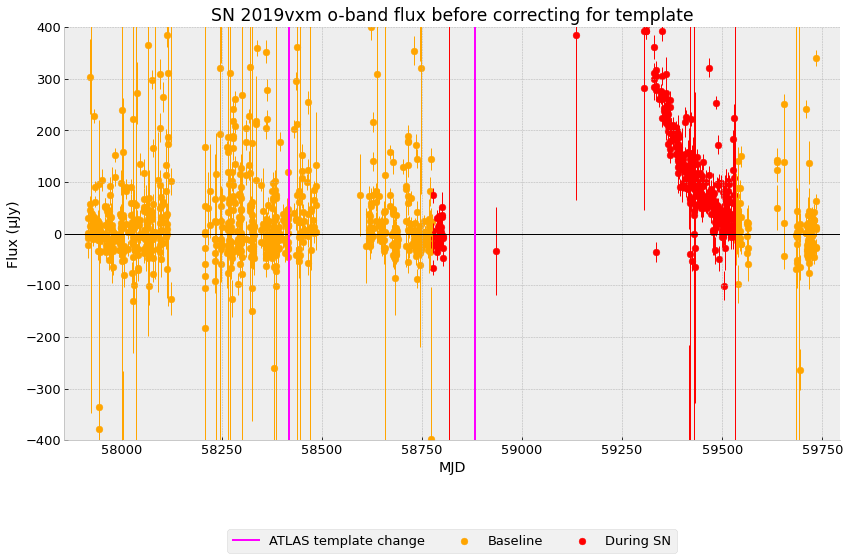

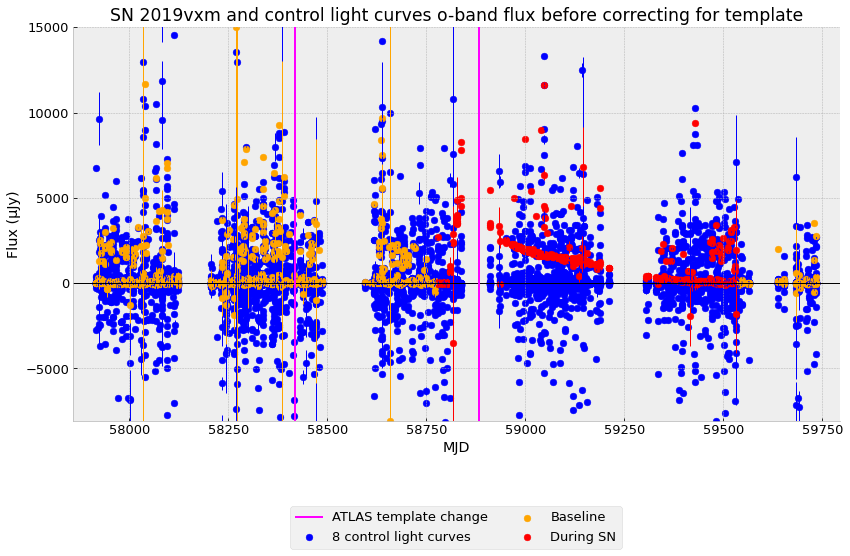

In [4]:
# get discovery date if needed, load in light curve, account for template changes, 
# and add uJy/duJy column

def get_tns_data(tnsname, api_key):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':api_key,'data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error: \n'+str(e)

def get_discdate(tnsname, api_key):
	json_data = get_tns_data(tnsname, api_key)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+'T'+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	return disc_date

def get_xth_percentile_flux(lc_type, percentile, indices=None):
    if indices is None:
        indices = lc_info[lc_type].getindices()
    if len(indices)==0: 
        return None
    else:
        return np.percentile(lc_info[lc_type].t.loc[indices, 'uJy'], percentile)

def save_lc(lc_type, filename, overwrite=False):
    print('Saving light curve at %s' % filename)
    lc_info[lc_type].write(filename,overwrite=overwrite)

def plot_lc(add2title=None, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.axhline(linewidth=1,color='k')
    plt.ylabel('Flux (µJy)')
    plt.xlabel('MJD')
    title = 'SN %s %s-band flux' % (lc_info['tnsname'],lc_info['filter'])
    if not(add2title is None):
        title += add2title
    plt.title(title)
    plt.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    plt.axvline(x=tchange2,color='magenta')

    color = 'orange' if lc_info['filter'] == 'o' else 'cyan'

    # set x and y limits
    if xlim_lower is None: xlim_lower = lc_info['lc'].t['MJD'].min() * 0.999
    if xlim_upper is None: xlim_upper = lc_info['lc'].t['MJD'].max() * 1.001
    if ylim_lower is None: ylim_lower = lc_info['lc'].t['uJy'].min()
    if ylim_upper is None: ylim_upper = lc_info['lc'].t['uJy'].max()
    plt.xlim(xlim_lower,xlim_upper)
    plt.ylim(ylim_lower,ylim_upper)

    plt.errorbar(lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'uJy'], yerr=lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'duJy'], fmt='none',ecolor=color,elinewidth=1,c=color)
    plt.scatter(lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'uJy'], s=45,color=color,marker='o',label='Baseline')
    
    plt.errorbar(lc_info['lc'].t.loc[lc_info['duringsn_i'],'MJD'], lc_info['lc'].t.loc[lc_info['duringsn_i'],'uJy'], lc_info['lc'].t.loc[lc_info['duringsn_i'],'duJy'], fmt='none',ecolor='red',elinewidth=1,c='red')
    plt.scatter(lc_info['lc'].t.loc[lc_info['duringsn_i'],'MJD'], lc_info['lc'].t.loc[lc_info['duringsn_i'],'uJy'], s=45,color='red',marker='o',label='During SN')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

def plot_control_lcs(add2title=None, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    color = 'orange' if lc_info["filter"] == 'o' else 'cyan'

    fig = plt.figure(figsize=(12,8), tight_layout=True)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.axhline(linewidth=1,color='k')
    plt.ylabel('Flux (µJy)')
    plt.xlabel('MJD')
    title = f'SN {lc_info["tnsname"]} and control light curves {lc_info["filter"]}-band flux'
    if not(add2title is None):
        title += add2title
    plt.title(title)
    plt.axvline(x=tchange1, color='magenta', label='ATLAS template change')
    plt.axvline(x=tchange2, color='magenta')

    # set x and y limits
    if xlim_lower is None: xlim_lower = lc_info['lc'].t['MJD'].min() * 0.999
    if xlim_upper is None: xlim_upper = lc_info['lc'].t['MJD'].max() * 1.001
    if ylim_lower is None: ylim_lower = lc_info['lc'].t['uJy'].min()
    if ylim_upper is None: ylim_upper = lc_info['lc'].t['uJy'].max()
    plt.xlim(xlim_lower,xlim_upper)
    plt.ylim(ylim_lower,ylim_upper)

    for control_index in range(1,Ncontrols+1):
        plt.errorbar(controls[control_index].t['MJD'], controls[control_index].t['uJy'], yerr=controls[control_index].t['duJy'], fmt='none',ecolor='blue',elinewidth=1,c='blue')
        if control_index == 1:
            plt.scatter(controls[control_index].t['MJD'], controls[control_index].t['uJy'], s=45,color='blue',marker='o',label=f'{Ncontrols} control light curves')
        else:
            plt.scatter(controls[control_index].t['MJD'], controls[control_index].t['uJy'], s=45,color='blue',marker='o')

    plt.errorbar(lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'uJy'], yerr=lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'duJy'], fmt='none',ecolor=color,elinewidth=1,c=color)
    plt.scatter(lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'MJD'],lc_info['lc'].t.loc[lc_info['baseline_revised_i'],'uJy'], s=45,color=color,marker='o',label='Baseline')
	
    plt.errorbar(lc_info['lc'].t.loc[lc_info['duringsn_i'],'MJD'], lc_info['lc'].t.loc[lc_info['duringsn_i'],'uJy'], lc_info['lc'].t.loc[lc_info['duringsn_i'],'duJy'], fmt='none',ecolor='red',elinewidth=1,c='red')
    plt.scatter(lc_info['lc'].t.loc[lc_info['duringsn_i'],'MJD'], lc_info['lc'].t.loc[lc_info['duringsn_i'],'uJy'], s=45,color='red',marker='o',label='During SN')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

def verify_mjds(Ncontrols):
    # sort sn lc by mjd
    mjd_sorted_i = lc_info['lc'].ix_sort_by_cols('MJD')
    lc_info['lc'].t = lc_info['lc'].t.loc[mjd_sorted_i]
    sn_sorted = lc_info['lc'].t.loc[mjd_sorted_i,'MJD'].to_numpy()

    for control_index in range(1,Ncontrols+1):
        # sort control lc by mjd
        mjd_sorted_i = controls[control_index].ix_sort_by_cols('MJD')
        control_sorted = controls[control_index].t.loc[mjd_sorted_i,'MJD'].to_numpy()
        
        # compare control lc to sn lc and, if out of agreement, fix
        if (len(sn_sorted) != len(control_sorted)) or (np.array_equal(sn_sorted, control_sorted) is False):
            print('\nMJDs out of agreement for control light curve %03d, fixing...' % control_index)

            mjds_onlysn = AnotB(sn_sorted, control_sorted)
            mjds_onlycontrol = AnotB(control_sorted, sn_sorted)

            # for the mjds only in sn, add row with that mjd to control lc, with all values of other columns NaN
            if len(mjds_onlysn) > 0:
                print('# Adding %d NaN rows to control light curve...' % len(mjds_onlysn))
                for mjd in mjds_onlysn:
                    controls[control_index].newrow({'MJD':mjd,'Mask':0})
            
            # remove indices of rows in control lc for which there is no mjd in the sn lc
            if len(mjds_onlycontrol) > 0:
                print('# Removing %d control light curve rows without matching SN rows...' % len(mjds_onlycontrol))
                indices2skip = []
                for mjd in mjds_onlycontrol:
                    ix = controls[control_index].ix_equal('MJD',mjd)
                    if len(ix)!=1:
                        raise RuntimeError(f'# Couldn\'t find MJD={mjd} in column MJD, but should be there!')
                    indices2skip.extend(ix)
                indices = AnotB(controls[control_index].getindices(),indices2skip)
            else:
                indices = controls[control_index].getindices()
            
            ix_sorted = controls[control_index].ix_sort_by_cols('MJD',indices=indices)
            controls[control_index].t = controls[control_index].t.loc[ix_sorted]
    print('\nFinished sorting SN and control light curves')

def load_control_lcs(controls_dir, Ncontrols): 
	for control_index in range(1,Ncontrols+1):
		controls[control_index] = pdastrostatsclass()
		filename = controls_dir + lc_info['tnsname'] + '_i%03d.'%control_index + lc_info['filter'] + '.lc.txt'
		print('Loading control light curve at ',filename)
		controls[control_index].load_spacesep(filename,delim_whitespace=True)

		# clear any previous control light curve flags
		controls[control_index].t['Mask'] = np.bitwise_and(controls[control_index].t['Mask'],(flag_chisquare|flag_uncertainty))

def get_Ndays(SN_region_index):
	return 200 if SN_region_index == 2 else 40

def set_baseline_region(regions, region_index, start_override=None, end_override=None):
	if not(start_override is None) and not(end_override) is None:
		regions['b_t%d'%region_index] = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=start_override, uplim=end_override)
	elif not(start_override is None):
		regions['b_t%d'%region_index] = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=start_override, uplim=lc_info['lc'].t.loc[regions['b_t%d'%region_index][-1],'MJD'])
	elif not(end_override is None):
		regions['b_t%d'%region_index] = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=lc_info['lc'].t.loc[regions['b_t%d'%region_index][0],'MJD'], uplim=end_override)
	return regions

def set_baseline_regions(regions):
	for region_index in range(0,3):
		start_override = input('Override template region b_t%d START MJD (n to skip): ' % region_index)
		end_override = input('Override template region b_t%d END MJD (n to skip): ' % region_index)

		if start_override.isdigit() and end_override.isdigit():
			print('# Overriding START for template region b_t%d with %f and END with %f: ' % (region_index,float(start_override),float(end_override)))
			regions = set_baseline_region(regions, region_index, start_override=float(start_override), end_override=float(end_override))
		elif start_override.isdigit():
			print('# Overriding START for template region b_t%d with %f: ' % (region_index,float(start_override)))
			regions = set_baseline_region(regions, region_index, start_override=float(start_override))
		elif end_override.isdigit():
			print('# Overriding END for template region b_t%d with %f: ' % (region_index,float(end_override)))
			regions = set_baseline_region(regions, region_index, end_override=float(end_override))
		else:
			print('# Skipping region... ')

	lc_info['baseline_revised_i'] = np.concatenate([regions['b_t0'],regions['b_t1'],regions['b_t2']])
	lc_info['duringsn_i'] = AnotB(lc_info['lc'].getindices(),lc_info['baseline_revised_i'])

	return regions

def get_baseline_regions(Ndays_min):
	print('Getting region indices around SN... ')
	regions = {}
	regions['t0']   = lc_info['lc'].ix_inrange(colnames=['MJD'],                  uplim=tchange1)
	regions['t1']   = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=tchange1, uplim=tchange2)
	regions['t2']   = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=tchange2)
	regions['b_t0'] = AandB(regions['t0'], lc_info['baseline_i'])
	regions['b_t1'] = AandB(regions['t1'], lc_info['baseline_i'])
	regions['b_t2'] = AandB(regions['t2'], lc_info['baseline_i'])

	# find region SN starts in 
	"""
	SN_region_index = None
	for region_index in range(0,3):
		region_i = regions['t%d' % region_index]
		if lc_info['discdate'] >= lc_info['lc'].t.loc[region_i[0],'MJD'] and lc_info['discdate'] <= lc_info['lc'].t.loc[region_i[-1],'MJD']:
			SN_region_index = region_index
	if SN_region_index is None:
		print('# ERROR: could not find region with SN discovery date; something is wrong, exiting... ')
		sys.exit()
	else:
		print('# SN discovery date located in template region t%d' % SN_region_index)
	"""
	# find region SN starts in 
	SN_region_index = None
	if lc_info['discdate']<= tchange1:
		SN_region_index = 0
	elif lc_info['discdate'] > tchange1 and lc_info['discdate'] <= tchange2:
		SN_region_index = 1
	elif lc_info['discdate'] > tchange2:
		SN_region_index = 2
	if SN_region_index is None:
		raise RuntimeError('# ERROR: Something went wrong--could not find region with SN discovery date!')
	else:
		print('# SN discovery date located in template region t%d' % SN_region_index)

	# for region with tail end of the SN, get last Ndays days and classify as baseline
	adjust_region_index = SN_region_index
	if adjust_region_index < 2 and len(regions['b_t%d'%adjust_region_index]) >= Ndays_min:
		adjust_region_index += 1
	if len(regions['b_t%d'%adjust_region_index]) < Ndays_min:
		print('# Getting baseline flux for template region t%d by obtaining last %d days of region... ' % (adjust_region_index, get_Ndays(adjust_region_index)))
		regions['b_t%d'%adjust_region_index] = lc_info['lc'].ix_inrange(colnames=['MJD'],
																		lowlim=lc_info['lc'].t.loc[regions['t%d'%adjust_region_index][-1],'MJD']- get_Ndays(adjust_region_index),
																		uplim=lc_info['lc'].t.loc[regions['t%d'%adjust_region_index][-1],'MJD'])
	if adjust_region_index < 1: regions['b_t1'] = regions['t1']
	if adjust_region_index < 2: regions['b_t2'] = regions['t2']

	for region_index in range(0,3):
		if len(regions['t%d'%region_index]) > 0:
			print('# TEMPLATE REGION t%d MJD RANGE: %0.2f - %0.2f' % (region_index, lc_info['lc'].t.loc[regions['t%d'%region_index][0],'MJD'], lc_info['lc'].t.loc[regions['t%d'%region_index][-1],'MJD']))
		else:
			print('# TEMPLATE REGION t%d MJD RANGE: not found' % region_index)
		if len(regions['b_t%d'%region_index]) > 0:
			print('# TEMPLATE REGION b_t%d BASELINE MJD RANGE: %0.2f - %0.2f' % (region_index, lc_info['lc'].t.loc[regions['b_t%d'%region_index][0],'MJD'], lc_info['lc'].t.loc[regions['b_t%d'%region_index][-1],'MJD']))
		else:
			print('# TEMPLATE REGION b_t%d BASELINE MJD RANGE: not found' % region_index)

	# check to make sure baseline flux is still consistent by getting median of first and last halves of affected region
	first_i = regions['b_t%d'%adjust_region_index][0]
	mid_i   = regions['b_t%d'%adjust_region_index][int(len(regions['b_t%d'%adjust_region_index])/2)]
	last_i  = regions['b_t%d'%adjust_region_index][-1]
	median1 = np.median(lc_info['lc'].t.loc[lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=lc_info['lc'].t.loc[first_i,'MJD'], uplim=lc_info['lc'].t.loc[mid_i,'MJD']), 'uJy'])
	median2 = np.median(lc_info['lc'].t.loc[lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=lc_info['lc'].t.loc[mid_i+1,'MJD'], uplim=lc_info['lc'].t.loc[last_i,'MJD']), 'uJy'])
	print('# Checking that baseline flux is consistent throughout adjusted region...\n## Median of first half: %0.2f\n## Median of second half: %0.2f' % (median1,median2))

	lc_info['baseline_revised_i'] = np.concatenate([regions['b_t0'],regions['b_t1'],regions['b_t2']])
	lc_info['duringsn_i'] = AnotB(lc_info['lc'].getindices(),lc_info['baseline_revised_i'])
	return regions

def count_valid_regions(regions):
	count = 0
	for region_index in range(0,3):
		if len(regions['b_t%d'%region_index]) > 0:
			count += 1
	return count

def plot_fdf(ax, region_i, b_goodx2_i, b_badx2_i, median=None, xlim_lower=None, xlim_upper=None):
	ax.set_title('Region (MJD): %d-%d' % (lc_info['lc'].t.loc[region_i[0],'MJD'], lc_info['lc'].t.loc[region_i[-1],'MJD']), size=15)
	ax.set_xlabel('Flux (µJy)')
	plt.axvline(x=median,color='magenta')
	plt.gca().spines['right'].set_visible(False)
	plt.gca().spines['top'].set_visible(False)
	if len(lc_info['baseline_i'])>0: 
		if xlim_lower is None: 
			xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_revised_i'], 'uJy'])
		if xlim_upper is None:
			xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_revised_i'], 'uJy'])
		ax.hist(lc_info['lc'].t.loc[AandB(region_i,b_goodx2_i), 'uJy'], bins=30, color='orange', alpha=0.5, range=(xlim_lower,xlim_upper), density=True)
		ax.hist(lc_info['lc'].t.loc[AandB(region_i,b_badx2_i), 'uJy'], bins=30, color='blue', alpha=0.5, range=(xlim_lower,xlim_upper), density=True)
	else:
		ax.hist(lc_info['lc'].t.loc[AandB(region_i,b_goodx2_i), 'uJy'], bins=30, color='orange', alpha=0.5, density=True)
		ax.hist(lc_info['lc'].t.loc[AandB(region_i,b_badx2_i), 'uJy'], bins=30, color='blue', alpha=0.5, density=True)

def begin_correct4template(Ndays_min, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
	# automatically define baseline regions
	regions = get_baseline_regions(Ndays_min)

	if ylim_lower is None: ylim_lower = -400
	if ylim_upper is None: ylim_upper = 400 #ylim_upper = 1.3*get_xth_percentile_flux('lc', 95, lc_info['baseline_i'])
	plot_lc(add2title=' before correcting for template', xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

	return regions

# correct control light curves for atlas template changes by 
# getting median of same baseline regions as SN, then applying to entire region
def controls_correct_for_template(control_index, regions, region_index):
		b_goodx2_i = controls[control_index].ix_inrange(colnames=['chi/N'], uplim=5)

		lowlim = lc_info['lc'].t.loc[regions[f'b_t{region_index}'][0], 'MJD']
		uplim= lc_info['lc'].t.loc[regions[f'b_t{region_index}'][-1], 'MJD']
		b_region_i = controls[control_index].ix_inrange(colnames=['MJD'], lowlim=lowlim, uplim=uplim, exclude_uplim=True)

		if len(b_region_i) > 0:
			print(f'### Adjusting for template change in region b_t{region_index} from {lowlim:0.2f}-{uplim:0.2f}...')
			print(f'### Baseline median before: {np.median(controls[control_index].t.loc[b_region_i,"uJy"])}')
						
			if len(AandB(b_region_i,b_goodx2_i)) > 0:
				median = np.median(controls[control_index].t.loc[AandB(b_region_i,b_goodx2_i),'uJy'])
			else:
				median = np.median(controls[control_index].t.loc[b_region_i,'uJy'])

			lowlim = lc_info['lc'].t.loc[regions[f't{region_index}'][0], 'MJD']
			uplim = lc_info['lc'].t.loc[regions[f't{region_index}'][-1], 'MJD']
			t_region_i = controls[control_index].ix_inrange(colnames=['MJD'], lowlim=lowlim, uplim=uplim, exclude_uplim=True)

			print(f'### Subtracting median {median:0.1f} uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...')
			controls[control_index].t.loc[t_region_i,'uJy'] -= median
			print(f'### Baseline median now: {np.median(controls[control_index].t.loc[b_region_i,"uJy"])}')
		else:
			print(f'### No baseline region for region b_t{region_index}, skipping...')

def correct4template(regions, fdf_xlim_lower=None, fdf_xlim_upper=None, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
	if ylim_lower is None: ylim_lower = -400
	if ylim_upper is None: ylim_upper = 400 #ylim_upper = 1.3*get_xth_percentile_flux('lc', 95, lc_info['baseline_i'])

	# user can manually override baseline region endpoints
	if input('Override baseline region endpoint(s)? (y/n)') == 'y':
		regions = set_baseline_regions(regions)
		plot_lc(add2title=' before correcting for template', xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

	b_goodx2_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=5,indices=lc_info['baseline_revised_i'])
	b_badx2_i = AnotB(lc_info['baseline_revised_i'],b_goodx2_i)
	fig = plt.figure(figsize=(10, 5), tight_layout=True)
	plt.suptitle('SN %s %s-band baseline flux distribution before correcting for template' % (lc_info['tnsname'], lc_info['filter']), fontsize=17, y=1)
	
	for region_index in range(0,3):
		region_i = regions['b_t%d'%region_index]
		if len(region_i) > 0:
			print('\nAdjusting for template change in region b_t%d from %0.2f-%0.2f ' % (region_index, lc_info['lc'].t.loc[region_i[0],'MJD'], lc_info['lc'].t.loc[region_i[-1],'MJD']))
			print('# Baseline median before: ', np.median(lc_info['lc'].t.loc[region_i,'uJy']))
			if len(AandB(region_i,b_goodx2_i)) > 0:
				median = np.median(lc_info['lc'].t.loc[AandB(region_i,b_goodx2_i),'uJy'])
			else:
				median = np.median(lc_info['lc'].t.loc[region_i,'uJy'])
			
			ax = fig.add_subplot(1, count_valid_regions(regions), region_index+1)
			plot_fdf(ax, region_i, b_goodx2_i, b_badx2_i, median=median, xlim_lower=fdf_xlim_lower, xlim_upper=fdf_xlim_upper)
			
			print(f'# Subtracting median {median:0.1f} uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...')
			lc_info['lc'].t.loc[regions['t%d'%region_index],'uJy'] -= median
			print('# Baseline median now: ', np.median(lc_info['lc'].t.loc[region_i,'uJy']))

			if load_controls:
				print(f'\n# Correcting control light curves for potential flux in template...')
				for control_index in range(1, Ncontrols+1):
					print(f'\n## Control index: {control_index}')
					controls_correct_for_template(control_index, regions, region_index)
		else:
			print('No baseline region for region b_t%d, skipping... ' % region_index)

	orange = mpatches.Patch(color='orange', alpha=0.5, label='Data with chi-square≤%d' % 5)
	blue = mpatches.Patch(color='blue', alpha=0.5, label='Data with chi-square>%d' % 5)
	magenta = mpatches.Patch(color='magenta', alpha=0.5, label='Median of baseline flux with chi-square≤%d' % 5)
	fig.legend(handles=[orange, blue, magenta], loc='upper center', bbox_to_anchor=(0.5, 0), frameon=True)

	plot_lc(add2title=' after correcting for template', xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

def drop_extra_columns(lc_type):
	dropcols=[]
	if 'Noffsetlc' in lc_info[lc_type].t.columns: dropcols.append('Noffsetlc')
	if '__tmp_SN' in lc_info[lc_type].t.columns: dropcols.append('__tmp_SN')
	for col in lc_info[lc_type].t.columns:
		if re.search('^c\d_',col): 
			dropcols.append(col)
	if len(dropcols)>0: 
		print('Dropping extra columns: ',dropcols)
		lc_info[lc_type].t.drop(columns=dropcols,inplace=True)

def load_lc(filename):
	lc_info['lc'] = pdastrostatsclass()
	try:
		print('Loading SN %s light curve at %s...' % (lc_info['tnsname'], filename))
		lc_info['lc'].load_spacesep(filename,delim_whitespace=True)
	except Exception as e:
		print('Could not load light curve for SN %s at %s: %s' % (lc_info['tnsname'], filename, str(e)))
		sys.exit()
	
	lc_info['baseline_i'] = lc_info['lc'].ix_inrange(colnames=['MJD'],uplim=lc_info['discdate']-20,exclude_uplim=True)
	if len(lc_info['baseline_i'])<=0:
		print('Baseline length is 0--cannot find best chi-square cut! Exiting...')
		sys.exit()
	lc_info['afterdiscdate_i'] = AnotB(lc_info['lc'].getindices(), lc_info['baseline_i']) 

lc_info['tnsname'] = tnsname

if filter != 'o' and filter != 'c': 
	print('Filter must be "o" or "c"!')
	sys.exit()
lc_info['filter'] = filter

if discdate is None:
	print('Obtaining SN %s discovery date from TNS...' % lc_info['tnsname'])
	discdate = get_discdate(lc_info['tnsname'], api_key)
	print('Discovery date: ',discdate)
lc_info['discdate'] = discdate - 20

load_lc(filename)
regions = begin_correct4template(Ndays_min, xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

print('\n')
load_control_lcs(controls_dir, Ncontrols)
verify_mjds(Ncontrols)
plot_control_lcs(add2title=' before correcting for template')


Adjusting for template change in region b_t0 from 57914.53-58416.29 
# Baseline median before:  23.0
# Subtracting median 0.0 uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...
# Baseline median now:  23.0

# Correcting control light curves for potential flux in template...

## Control index: 1
### Adjusting for template change in region b_t0 from 57914.53-58416.29...
### Baseline median before: 0.0
### Subtracting median 0.0 uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...
### Baseline median now: 0.0

## Control index: 2
### Adjusting for template change in region b_t0 from 57914.53-58416.29...
### Baseline median before: 0.0
### Subtracting median 0.0 uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...
### Baseline median now: 0.0

## Control index: 3
### Adjusting for template change in region b_t0 from 57914.53-58416.29...

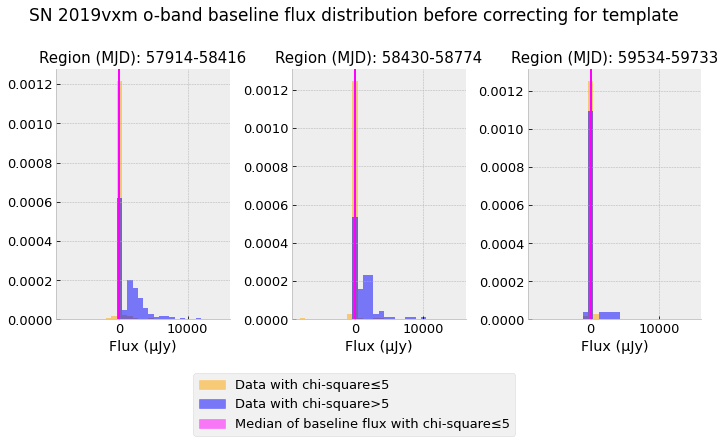

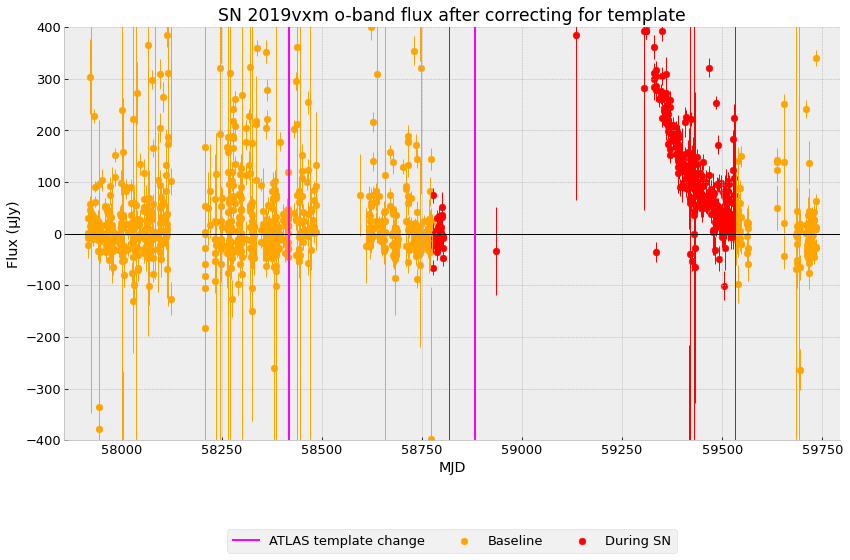

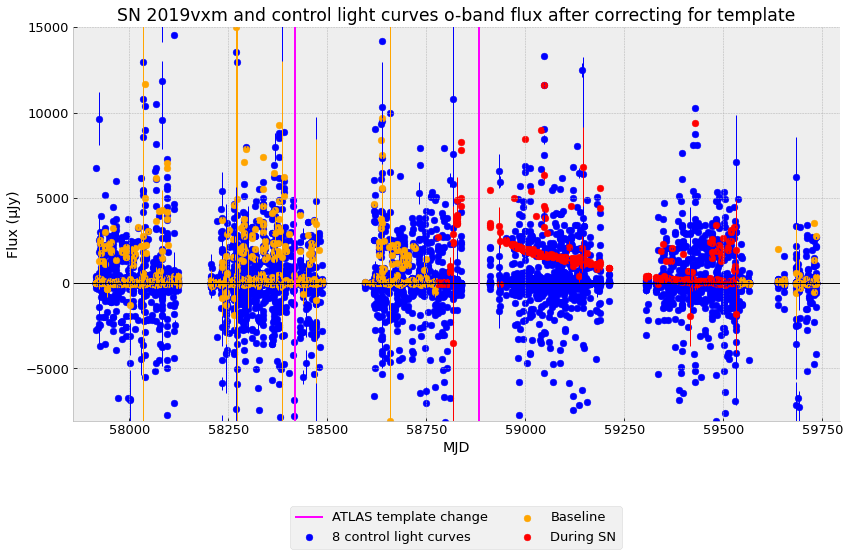

In [5]:
# using plot above, can manually redefine baseline endpoints within each template region; 
# then, adjust for template changes using baseline endpoints

correct4template(regions, fdf_xlim_lower=fdf_xlim_lower, fdf_xlim_upper=fdf_xlim_upper, xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)
plot_control_lcs(add2title=' after correcting for template')

drop_extra_columns('lc') # comment out this line if dropping columns is giving you unexpected trouble

# add flux/dflux column
print('Adding uJy/duJy column to light curve...')
lc_info['lc'].t['uJy/duJy'] = lc_info['lc'].t['uJy']/lc_info['lc'].t['duJy']
lc_info['lc'].t = lc_info['lc'].t.replace([np.inf, -np.inf], np.nan)

### Plot the ATLAS light curve

In [6]:
# Enter the scaling parameter for the SN plot's upper y limit 
# (ylim_upper = scale * 95th percentile flux):
scale = 3

# Optionally, manually enter the SN plot's x and y limits to override automatic scaling:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

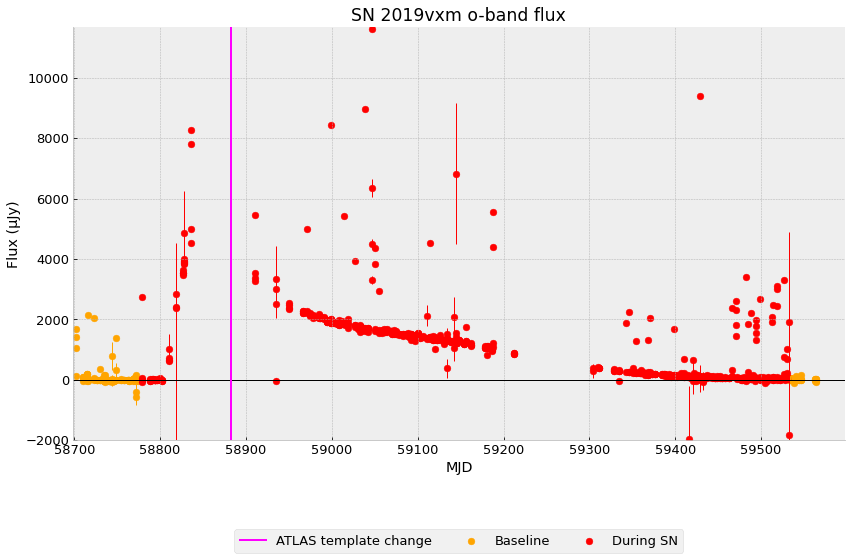

In [7]:
# plot the light curve

if xlim_lower is None: xlim_lower = lc_info['discdate'] - 200
if xlim_upper is None: xlim_upper = lc_info['discdate'] + 800
if ylim_lower is None: ylim_lower = -2000
if ylim_upper is None: ylim_upper = scale*get_xth_percentile_flux('lc', 97, lc_info['duringsn_i'])
plot_lc(xlim_lower=xlim_lower,xlim_upper=xlim_upper,ylim_lower=ylim_lower, ylim_upper=ylim_upper)

## Part 1: Dynamic Chi-Square Cut

### Plot the flux/dflux and chi-square distributions

The following two histograms display the flux/dflux and chi-square distributions of the target SN. Both histograms show probability density so as to ease comparison between the groups plotted within each histogram.

- The first histogram focuses on the baseline flux/dflux (µJy/dµJy) measurements, where we can expect the flux to equal 0. In orange, we plot flux/dflux (µJy/dµJy) measurements with a chi-square value less than or equal to `x2bound`, which is currently set to 5 below; in blue, we plot flux/dflux (µJy/dµJy) measurements with a chi-square value greater than `x2bound`. 
- The second histogram focuses on the baseline chi-square measurements. In green, we plot chi-square measurements with an abs(µJy/dµJy) value less than or equal to `stnbound`, which is currently set to 3 below; in red, we plot chi-square measurements with an abs(µJy/dµJy) value greater than `stnbound`. 

Ideally, all measurements with a chi-square value less than or equal to `x2bound` should have an abs(µJy/dµJy) value less than or equal to `stnbound`, and measurements with a chi-square value greater than `x2bound` should have an abs(µJy/dµJy) value greater than `stnbound`. Our goal is to separate good measurements from bad measurements using a chi-square cut; in order for our cut to be effective, these histograms should hopefully showcase this relation between the target SN's flux/dflux and chi-square measurements.

In [8]:
# Enter the bound that should separate a good chi-square measurement from a bad one:
x2bound = 5.0

# Enter the bound that should separate a good abs(flux/dflux) measurement from a bad one:
stnbound = 3.0

# Optionally, manually enter the histograms' x limits here:
# flux/dflux histogram x limits:
fdf_xlim_lower = None 
fdf_xlim_upper = None
# chi-square histogram x limits:
x2_xlim_lower = None
x2_xlim_upper = None

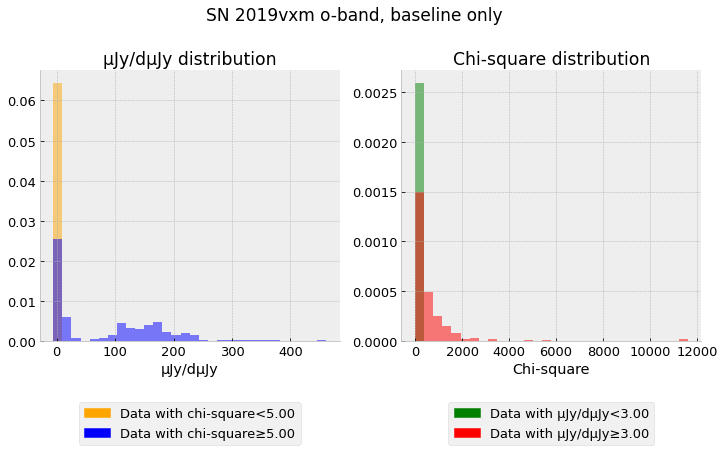

In [9]:
# plot flux/dflux and chi-square distribution histograms

def plot_hists(x2bound, stnbound, fdf_xlim_lower=None, fdf_xlim_upper=None, x2_xlim_lower=None, x2_xlim_upper=None):
    b_goodstn_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stnbound,uplim=stnbound,indices=lc_info['baseline_i'])
    b_badstn_i = AnotB(lc_info['baseline_i'],b_goodstn_i)
    b_goodx2_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=x2bound,indices=lc_info['baseline_i'])
    b_badx2_i = AnotB(lc_info['baseline_i'],b_goodx2_i)

    fig, (stn, x2) = plt.subplots(1, 2, figsize=(10, 6.5), tight_layout=True)
    plt.suptitle('SN %s %s-band, baseline only' % (lc_info['tnsname'], lc_info['filter']), fontsize=17, y=1)

    stn.set_title('µJy/dµJy distribution')
    stn.set_xlabel('µJy/dµJy')
    stn.spines.right.set_visible(False)
    stn.spines.top.set_visible(False)
    orange = mpatches.Patch(color='orange', label='Data with chi-square<%0.2f' % x2bound)
    blue = mpatches.Patch(color='blue', label='Data with chi-square≥%0.2f' % x2bound)
    stn.legend(handles=[orange, blue], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
    if len(lc_info['baseline_i'])>0: 
        if fdf_xlim_lower is None: 
            fdf_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        if fdf_xlim_upper is None: 
            fdf_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        stn.hist(lc_info['lc'].t.loc[b_goodx2_i, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
        stn.hist(lc_info['lc'].t.loc[b_badx2_i, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
    else:
        stn.hist(lc_info['lc'].t.loc[b_goodx2_i, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, density=True)
        stn.hist(lc_info['lc'].t.loc[b_badx2_i, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, density=True)

    x2.set_title('Chi-square distribution')
    x2.set_xlabel('Chi-square')
    x2.spines.right.set_visible(False)
    x2.spines.top.set_visible(False)
    red = mpatches.Patch(color='green', label='Data with µJy/dµJy<%0.2f' % stnbound)
    green = mpatches.Patch(color='red', label='Data with µJy/dµJy≥%0.2f' % stnbound)
    x2.legend(handles=[red, green], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
    if len(lc_info['baseline_i'])>0:
        if x2_xlim_lower is None: 
            x2_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'chi/N'])
        if x2_xlim_upper is None: 
            x2_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'chi/N'])
        x2.hist(lc_info['lc'].t.loc[b_goodstn_i, 'chi/N'], bins=30, color='green', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
        x2.hist(lc_info['lc'].t.loc[b_badstn_i, 'chi/N'], bins=30, color='red', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
    else:
        x2.hist(lc_info['lc'].t.loc[b_goodstn_i, 'chi/N'], bins=30, color='green', alpha=0.5, density=True)
        x2.hist(lc_info['lc'].t.loc[b_badstn_i, 'chi/N'], bins=30, color='red', alpha=0.5, density=True)

plot_hists(x2bound, stnbound, fdf_xlim_lower=fdf_xlim_lower, fdf_xlim_upper=fdf_xlim_upper, x2_xlim_lower=x2_xlim_lower, x2_xlim_upper=x2_xlim_upper)

### Calculate best chi-square cut based on contamination and loss

The following cells use two factors, <strong>contamination</strong> and <strong>loss</strong>, to attempt to calculate an optimal PSF chi-square cut for the target SN, with flux/dflux as the deciding factor of what constitutes a good measurement vs. a bad measurement. We aim to separate good measurements from bad using the calculated chi-square cut by removing as much contamination as possible with the smallest loss possible. Since we can assume that the expected value of the baseline flux is 0, we look only at the baseline measurements before the SN occurs in order to determine the best chi-square cut for the SN itself.

First, we decide what will determine a good measurement vs. a bad measurement using a factor outside of the chi-square values. Our chosen factor is the <strong>absolute value of flux (µJy) divided by dflux (dµJy)</strong>. The recommended boundary is a value of 3, such that any measurements with a value of abs(µJy/dµJy) less than or equal to 3 are regarded as "good" measurements, and any measurements with a value of abs(µJy/dµJy) greater than 3 are regarded as "bad" measurements. You can set this boundary to a different number by changing the value of `stn_cut` below.

Next, we set the upper and lower bounds of our final chi-square cut. We start at a low value of 3 (which can be changed by setting the value of `cut_start` below) and end at 50 (this value is inclusive and can be changed by setting the value of `cut_stop` below) with a step size of 1 (`cut_step` below). <strong>For chi-square cuts falling on or between `cut_start` and `cut_stop` in increments of `cut_step`, we can begin to calculate contamination and loss percentages.</strong>

We define contamination to be the number of bad kept measurements over the total number of kept measurements for that chi-square cut (<strong>contamination = Nbad,kept/Nkept</strong>). For our final chi-square cut, we can also set a limit on what maximum percent contamination we want to have--the recommended value is <strong>10%</strong> but can be changed by setting the value of `contam_lim` below.

We define loss to be the number of good cut measurements over the total number of good measurements for that chi-square cut (<strong>loss = Ngood,cut/Ngood</strong>). For our final chi-square cut, we can also set a limit on what maximum percent loss we want to have--the recommended value is <strong>10%</strong> but can be changed by setting the value of `loss_lim` below.

Finally, we define which limit (`contam_lim` or `loss_lim`) to prioritize in the event that an optimal chi-square cut fitting both limits is not found. The default prioritized limit is `loss_lim` but can be changed by setting the value of `lim_to_prioritize` below.

In [10]:
# Enter the abs(uJy/duJy) boundary that will determine a "good" measurement vs. "bad" measurement:
stn_cut = 3

# Enter the bounds for the final chi-square cut (minimum cut, maximum cut, and step):
cut_start = 3 # this is inclusive
cut_stop = 50 # this is inclusive
cut_step = 1

# Enter the contamination limit (contamination = Nbad,kept/Nkept must be <= contam_lim% 
# for the final chi-square cut):
contam_lim = 15.0

# Enter the loss limit (loss = Ngood,cut/Ngood must be >= loss_lim%
# for the final chi-square cut):
loss_lim = 10.0

# Enter the limit to prioritize (must be 'loss_lim' or 'contam_lim') in the event that
# one or both limits are not met:
lim_to_prioritize = 'loss_lim'

The following section describes in detail how we determine the final chi-square cut using the given contamination and loss limits.

For each given limit (contamination and loss), we calculate a range of valid cuts whose contamination/loss percentage is less than that limit and then choose a single cut within that valid range. Then, we pass through a decision tree to determine which of the two suggested cuts to use using a variety of factors (including the user's selected `lim_to_prioritize`).

When choosing the loss cut according to the loss percentage limit `loss_lim`:
- <strong>If all loss percentages are below the limit</strong> `loss_lim`, all cuts falling on or between `cut_start` and `cut_stop` are valid.
- <strong>If all loss percentages are above the limit</strong> `loss_lim`, a cut with the required loss percentage is not possible; therefore, any cuts with the smallest percentage of loss are valid.
- <strong>Otherwise</strong>, the valid range of cuts includes any cuts with the loss percentage less than or equal to the limit `loss_lim`.
- The chosen cut for this limit is the <strong>minimum cut</strong> within the stated valid range of cuts.

When choosing the loss cut according to the contamination percentage limit `contam_lim`:
- <strong>If all contamination percentages are below the limit</strong> `contam_lim`, all cuts falling on or between `cut_start` and `cut_stop` are valid.
- <strong>If all contamination percentages are above the limit</strong> `contam_lim`, a cut with the required contamination percentage is not possible; therefore, any cuts with the smallest percentage of contamination are valid.
- <strong>Otherwise</strong>, the valid range of cuts includes any cuts with the contamination percentage less than or equal to the limit `contam_lim`.
- The chosen cut for this limit is the <strong>maximum cut</strong> within the stated valid range of cuts.

After we have calculated two suggested cuts based on the loss and contamination percentage limits, we follow the decision tree in order to suggest a final cut:
- If both loss and contamination cut percentages were chosen from a range that spanned from `cut_start` to `cut_stop`, we set the final cut to `cut_start`.
- If one cut's percentage was chosen from a range that spanned from `cut_start` to `cut_stop` and the other cut's percentage was not, we set the final cut to the latter cut.
- If both percentages were chosen from ranges that fell above their respective limits, we suggest reselecting either or both limits.
- Otherwise, we take into account the user's prioritized limit `lim_to_prioritize`:
    - If the loss cut is greater than the contamination cut, we set the final cut to whichever cut is associated with `lim_to_prioritize`.
    - Otherwise, if `lim_to_prioritize` is set to `contam_lim`, we set the final cut to the loss cut, and if `lim_to_prioritize` is set to `loss_lim`, we set the final cut to the contamination cut.

Contamination limit: 15.00%
Loss limit: 10.00%
abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Static chi square cut at 50: 15.48% cut for baseline

Contamination cut according to given contam_limit, with 15.06% contamination and 0.14% loss: 16.59
Loss cut according to given loss_limit, with 8.33% contamination and 10.08% loss: 5.30
Valid chi-square cut range from 5.30 to 16.59! 
Prioritizing loss_lim and setting to 16.59... 

Final suggested chi-square cut is 16.59, with 15.06% contamination and 0.14% loss.


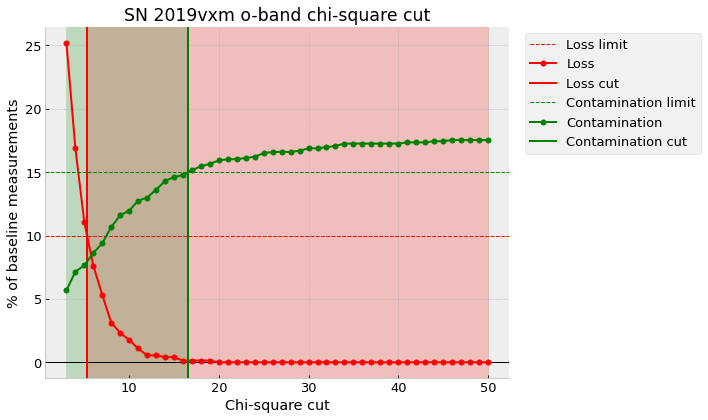

In [11]:
# calculate the suggested best chi-square cut using contamination and loss

def plot_lim_cuts(lim_cuts, contam_lim_cut, loss_lim_cut):
    fig = plt.figure(figsize=(10,6), tight_layout=True)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title('SN %s %s-band chi-square cut' % (lc_info['tnsname'],lc_info['filter']))

    plt.axhline(linewidth=1,color='k')
    plt.xlabel('Chi-square cut')
    plt.ylabel('% of baseline measurements')

    plt.axhline(loss_lim,linewidth=1,color='r',linestyle='--',label='Loss limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Ploss'],ms=5,color='r',marker='o',label='Loss')
    plt.axvline(x=loss_lim_cut,color='r',label='Loss cut')
    plt.axvspan(loss_lim_cut, cut_stop, alpha=0.2, color='r')

    plt.axhline(contam_lim,linewidth=1,color='g',linestyle='--',label='Contamination limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Pcontamination'],ms=5,color='g',marker='o',label='Contamination')
    plt.axvline(x=contam_lim_cut,color='g',label='Contamination cut')
    plt.axvspan(cut_start, contam_lim_cut, alpha=0.2, color='g')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    #fig.savefig('000001.png',bbox_inches="tight",dpi=200)

def choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case):
    # case 1 and 1: final_cut = 3
    # case 1 and 2: take limit of case 2
    # case 1 and 3: take limit of case 3
    # case 2 and 2: print lims don't work
    # case 2 and 3: choose_btwn_lim_cuts
    # case 3 and 3: choose_btwn_lim_cuts

    case1 = loss_case == 'below lim' or contam_case == 'below lim'
    case2 = loss_case == 'above lim' or contam_case == 'above lim'
    case3 = loss_case == 'crosses lim' or contam_case == 'crosses lim'

    final_cut = None
    if case1 and not case2 and not case3: # 1 and 1
        print('Valid chi-square cut range from %0.2f to %0.2f! Setting to 3...' % (loss_lim_cut, contam_lim_cut))
        final_cut = cut_start
    elif case1: # 1
        if case2: # and 2
            if loss_case == 'above lim':
                print('WARNING: contam_lim_cut <= %0.2f falls below limit %0.2f%%, but loss_lim_cut >= %0.2f falls above limit %0.2f%%! Setting to %0.2f...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('WARNING: loss_lim_cut <= %0.2f falls below limit %0.2f%%, but contam_lim_cut >= %0.2f falls above limit %0.2f%%! Setting to %0.2f...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
        else: # and 3
            if loss_case == 'crosses lim':
                print('Contam_lim_cut <= %0.2f falls below limit %0.2f%% and loss_lim_cut >= %0.2f crosses limit %0.2f%%, setting to %0.2f...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Loss_lim_cut <= %0.2f falls below limit %0.2f%% and contam_lim_cut >= %0.2f crosses limit %0.2f%%, setting to %0.2f...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
    elif case2 and not case3: # 2 and 2
        print('ERROR: chi-square loss_lim_cut >= %0.2f and contam_lim_cut <= %0.2f both fall above limits %0.2f%% and %0.2f%%! Try setting less strict limits. Setting final cut to nan.' % (loss_lim_cut, contam_lim_cut, loss_lim, contam_lim))
        final_cut = np.nan
    else: # 2 and 3 or 3 and 3
        if loss_lim_cut > contam_lim_cut:
            print('WARNING: chi-square loss_lim_cut >= %0.2f and contam_lim_cut <= %0.2f do not overlap! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %0.2f...' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
            else:
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
        else:
            print('Valid chi-square cut range from %0.2f to %0.2f! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
    return final_cut

def get_lim_cuts_data(cut, colname, indices=None):
    if indices is None:
        indices = lc_info['baseline_revised_i']

    b_good_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=indices)
    b_bad_i = AnotB(indices, b_good_i)
    b_kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=cut,indices=indices)
    b_cut_i = AnotB(indices, b_kept_i)

    lc_info['%s_Ngood' % colname] = len(b_good_i)
    lc_info['%s_Nbad' % colname] = len(b_bad_i)
    lc_info['%s_Nkept' % colname] = len(b_kept_i)
    lc_info['%s_Ncut' % colname] = len(b_cut_i)
    lc_info['%s_Ngood,kept' % colname] = len(AandB(b_good_i,b_kept_i))
    lc_info['%s_Ngood,cut' % colname] = len(AandB(b_good_i,b_cut_i))
    lc_info['%s_Nbad,kept' % colname] = len(AandB(b_bad_i,b_kept_i))
    lc_info['%s_Nbad,cut' % colname] = len(AandB(b_bad_i,b_cut_i))
    lc_info['%s_Pgood,kept' % colname] = 100*len(AandB(b_good_i,b_kept_i))/len(indices)
    lc_info['%s_Pgood,cut' % colname] = 100*len(AandB(b_good_i,b_cut_i))/len(indices)
    lc_info['%s_Pbad,kept' % colname] = 100*len(AandB(b_bad_i,b_kept_i))/len(indices)
    lc_info['%s_Pbad,cut' % colname] = 100*len(AandB(b_bad_i,b_cut_i))/len(indices)
    lc_info['%s_Ngood,kept/Ngood' % colname] = 100*len(AandB(b_good_i,b_kept_i))/len(b_good_i)
    lc_info['%s_Ploss' % colname] = 100*len(AandB(b_good_i,b_cut_i))/len(b_good_i)
    lc_info['%s_Pcontamination' % colname] = 100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i)

def get_lim_cuts(lim_cuts): 
    contam_lim_cut = None
    loss_lim_cut = None
    contam_case = None
    loss_case = None

    sortby_loss = lim_cuts.t.iloc[(lim_cuts.t['Ploss']).argsort()].reset_index()
    min_loss = sortby_loss.loc[0,'Ploss']
    max_loss = sortby_loss.loc[len(sortby_loss)-1,'Ploss']
    # if all loss below lim, loss_lim_cut is min cut
    if min_loss < loss_lim and max_loss < loss_lim:
        loss_case = 'below lim'
        loss_lim_cut = lim_cuts.t.loc[0,'PSF Chi-Square Cut']
    else:
        # else if all loss above lim, loss_lim_cut is min cut with min% loss
        if min_loss > loss_lim and max_loss > loss_lim:
            loss_case = 'above lim'
            a = np.where(lim_cuts.t['Ploss'] == min_loss)[0]
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            loss_lim_cut = c.loc[0,'PSF Chi-Square Cut']
        # else if loss crosses lim at some point, loss_lim_cut is min cut with max% loss <= loss_lim
        else:
            loss_case = 'crosses lim'
            valid_cuts = sortby_loss[sortby_loss['Ploss'] <= loss_lim]
            a = np.where(lim_cuts.t['Ploss'] == valid_cuts.loc[len(valid_cuts)-1,'Ploss'])[0]
            # sort by cuts
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            # get midpoint of loss1 and loss2 (two points on either side of lim)
            loss1_i = np.where(lim_cuts.t['PSF Chi-Square Cut'] == c.loc[0,'PSF Chi-Square Cut'])[0][0]
            if lim_cuts.t.loc[loss1_i,'Ploss'] == loss_lim:
                loss_lim_cut = lim_cuts.t.loc[loss1_i,'PSF Chi-Square Cut']
            else:
                loss2_i = loss1_i - 1
                x = np.array([lim_cuts.t.loc[loss1_i,'PSF Chi-Square Cut'], lim_cuts.t.loc[loss2_i,'PSF Chi-Square Cut']])
                contam_y = np.array([lim_cuts.t.loc[loss1_i,'Pcontamination'], lim_cuts.t.loc[loss2_i,'Pcontamination']])
                loss_y = np.array([lim_cuts.t.loc[loss1_i,'Ploss'], lim_cuts.t.loc[loss2_i,'Ploss']])
                contam_line = np.polyfit(x,contam_y,1)
                loss_line = np.polyfit(x,loss_y,1)
                loss_lim_cut = (loss_lim-loss_line[1])/loss_line[0]

    sortby_contam = lim_cuts.t.iloc[(lim_cuts.t['Pcontamination']).argsort()].reset_index()
    min_contam = sortby_contam.loc[0,'Pcontamination']
    max_contam = sortby_contam.loc[len(sortby_contam)-1,'Pcontamination']
    # if all contam below lim, contam_lim_cut is max cut
    if min_contam < contam_lim and max_contam < contam_lim:
        contam_case = 'below lim'
        contam_lim_cut = lim_cuts.t.loc[len(lim_cuts.t)-1,'PSF Chi-Square Cut']
    else:
        # else if all contam above lim, contam_lim_cut is max cut with min% contam
        if min_contam > contam_lim and max_contam > contam_lim:
            contam_case = 'above lim'
            a = np.where(lim_cuts.t['Pcontamination'] == min_contam)[0]
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            contam_lim_cut = c.loc[len(c)-1,'PSF Chi-Square Cut']
        # else if contam crosses lim at some point, contam_lim_cut is max cut with max% contam <= contam_lim
        else:
            contam_case = 'crosses lim'
            valid_cuts = sortby_contam[sortby_contam['Pcontamination'] <= contam_lim]
            a = np.where(lim_cuts.t['Pcontamination'] == valid_cuts.loc[len(valid_cuts)-1,'Pcontamination'])[0]
            # sort by cuts
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            # get midpoint of contam1 and contam2 (two points on either side of lim)
            contam1_i = np.where(lim_cuts.t['PSF Chi-Square Cut'] == c.loc[len(c)-1,'PSF Chi-Square Cut'])[0][0]
            if lim_cuts.t.loc[contam1_i,'Pcontamination'] == contam_lim:
                contam_lim_cut = lim_cuts.t.loc[contam1_i,'PSF Chi-Square Cut']
            else:
                contam2_i = contam1_i + 1
                x = np.array([lim_cuts.t.loc[contam1_i,'PSF Chi-Square Cut'], lim_cuts.t.loc[contam2_i,'PSF Chi-Square Cut']])
                contam_y = np.array([lim_cuts.t.loc[contam1_i,'Pcontamination'], lim_cuts.t.loc[contam2_i,'Pcontamination']])
                loss_y = np.array([lim_cuts.t.loc[contam1_i,'Ploss'], lim_cuts.t.loc[contam2_i,'Ploss']])
                contam_line = np.polyfit(x,contam_y,1)
                loss_line = np.polyfit(x,loss_y,1)
                contam_lim_cut = (contam_lim-contam_line[1])/contam_line[0]

    get_lim_cuts_data(loss_lim_cut, 'loss_lim_cut')
    get_lim_cuts_data(contam_lim_cut, 'contam_lim_cut')

    return contam_lim_cut, loss_lim_cut, contam_case, loss_case

def get_lim_cuts_table(stn_cut, cut_start, cut_stop, cut_step, indices=None):
    print('abs(uJy/duJy) cut at %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (stn_cut,cut_start,cut_stop,cut_step))

    if indices is None: 
        indices = lc_info['baseline_revised_i']

    lim_cuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                          'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Ploss', 'Pcontamination',
                                          'Nbad,cut 3<stn<=5', 'Nbad,cut 5<stn<=10', 'Nbad,cut 10<stn', 'Nbad,kept 3<stn<=5', 'Nbad,kept 5<stn<=10', 'Nbad,kept 10<stn'])
    
    # static cut at x2 = 50
    x2cut_50 = np.where(lc_info['lc'].t['chi/N'] < 50)[0]
    print('Static chi square cut at 50: %0.2f%% cut for baseline' % (100*len(AnotB(indices,x2cut_50))/len(indices)))

    # good baseline measurement indices
    b_good_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=indices)
    b_bad_i = AnotB(indices, b_good_i)
    # for different x2 cuts decreasing from 50
    for cut in range(cut_start,cut_stop+1,cut_step):
        # kept baseline measurement indices
        b_kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=cut,indices=indices)
        b_cut_i = AnotB(indices, b_kept_i)

        df = pd.DataFrame([[cut, len(indices), # N
                            len(b_good_i), # Ngood
                            len(b_bad_i), # Nbad
                            len(b_kept_i), # Nkept
                            len(b_cut_i), # Ncut
                            len(AandB(b_good_i,b_kept_i)), # Ngood,kept
                            len(AandB(b_good_i,b_cut_i)), # Ngood,cut
                            len(AandB(b_bad_i,b_kept_i)), # Nbad,kept
                            len(AandB(b_bad_i,b_cut_i)), # Nbad,cut
                            100*len(AandB(b_good_i,b_kept_i))/len(indices), # Ngood,kept/Nbaseline
                            100*len(AandB(b_good_i,b_cut_i))/len(indices), # Ngood,cut/Nbaseline 
                            100*len(AandB(b_bad_i,b_kept_i))/len(indices), # Nbad,kept/Nbaseline
                            100*len(AandB(b_bad_i,b_cut_i))/len(indices), # Nbad,cut/Nbaseline
                            100*len(AandB(b_good_i,b_kept_i))/len(b_good_i), # Ngood,kept/Ngood
                            100*len(AandB(b_good_i,b_cut_i))/len(b_good_i), # Ngood,cut/Ngood = Loss
                            100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i), # Nbad,kept/Nkept = Contamination
                            len(AandB(AandB(b_bad_i,b_cut_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-3,uplim=5,exclude_lowlim=True))), # Nbad,cut 3<stn<=5
                            len(AandB(AandB(b_bad_i,b_cut_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=5,uplim=10,exclude_lowlim=True))), # Nbad,cut 5<stn<=10
                            len(AandB(AandB(b_bad_i,b_cut_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=10,exclude_lowlim=True))), # Nbad,cut 10<stn 
                            len(AandB(AandB(b_bad_i,b_kept_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-3,uplim=5,exclude_lowlim=True))), # Nbad,kept 3<stn<=5
                            len(AandB(AandB(b_bad_i,b_kept_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=5,uplim=10,exclude_lowlim=True))), # Nbad,kept 5<stn<=10
                            len(AandB(AandB(b_bad_i,b_kept_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=10,exclude_lowlim=True))), # Nbad,kept 10<stn 
                            ]], columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                         'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Ploss', 'Pcontamination',
                                         'Nbad,cut 3<stn<=5', 'Nbad,cut 5<stn<=10', 'Nbad,cut 10<stn', 'Nbad,kept 3<stn<=5', 'Nbad,kept 5<stn<=10', 'Nbad,kept 10<stn'])
        lim_cuts.t = pd.concat([lim_cuts.t,df],ignore_index=True)
    return lim_cuts

if lim_to_prioritize != 'loss_lim' and lim_to_prioritize != 'contam_lim':
    print("ERROR: lim_to_prioritize must be 'loss_lim' or 'contam_lim'!")
    sys.exit()
print('Contamination limit: %0.2f%%\nLoss limit: %0.2f%%' % (contam_lim,loss_lim))

lim_cuts = get_lim_cuts_table(stn_cut, cut_start, cut_stop, cut_step)
contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lim_cuts)
lc_info['contam_case'] = contam_case
lc_info['loss_case'] = loss_case
lc_info['contam_lim_cut'] = contam_lim_cut
lc_info['loss_lim_cut'] = loss_lim_cut

print('\nContamination cut according to given contam_limit, with %0.2f%% contamination and %0.2f%% loss: %0.2f' % (lc_info['contam_lim_cut_Pcontamination'], lc_info['contam_lim_cut_Ploss'], contam_lim_cut))
if lc_info['contam_case'] == 'above lim':
    print('WARNING: Contamination cut not possible with contamination <= contam_lim %0.1f!' % contam_lim)
print('Loss cut according to given loss_limit, with %0.2f%% contamination and %0.2f%% loss: %0.2f' % (lc_info['loss_lim_cut_Pcontamination'], lc_info['loss_lim_cut_Ploss'], loss_lim_cut))
if lc_info['loss_case'] == 'above lim':
    print('WARNING: Loss cut not possible with loss <= loss_lim %0.2f!' % loss_lim)

final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)
lc_info['final_cut'] = final_cut
        
if np.isnan(final_cut):
    print('\nERROR: Final suggested chi-square cut could not be determined. We suggest rethinking your contamination and loss limits.')
    lc_info['Pcontamination'] = np.nan
    lc_info['Ploss'] = np.nan
else:
    if final_cut==contam_lim_cut:
        lc_info['Pcontamination'] = lc_info['contam_lim_cut_Pcontamination']
        lc_info['Ploss'] = lc_info['contam_lim_cut_Ploss']
    else:
        lc_info['Pcontamination'] = lc_info['loss_lim_cut_Pcontamination']
        lc_info['Ploss'] = lc_info['loss_lim_cut_Ploss']
    print('\nFinal suggested chi-square cut is %0.2f, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lc_info['Pcontamination'], lc_info['Ploss']))
    if (lc_info['Pcontamination'] > contam_lim):
        print('WARNING: Final cut\'s contamination %0.2f%% exceeds contam_lim %0.2f%%!' % (lc_info['Pcontamination'],contam_lim))
    if (lc_info['Ploss'] > loss_lim):
        print('WARNING: Final cut\'s loss exceeds %0.2f%% loss_lim %0.2f%%!' % (lc_info['Ploss'],loss_lim))

plot_lim_cuts(lim_cuts, contam_lim_cut, loss_lim_cut)

In [12]:
# confirm the final chi-square cut; if not, ask for user override

answer = input('Accept final chi-square cut of %0.2f (y/n):' % float(lc_info['final_cut']))
if answer != 'y':
    final_cut_override = float(input('Overriding final chi-square cut; enter manual cut: '))

    b_good_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=lc_info['baseline_i'])
    b_bad_i = AnotB(lc_info['baseline_i'], b_good_i)
    b_kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=final_cut_override,indices=lc_info['baseline_i'])
    b_cut_i = AnotB(lc_info['baseline_i'], b_kept_i)
    lc_info['Ploss'] = 100*len(AandB(b_good_i,b_cut_i))/len(b_good_i)
    lc_info['Pcontamination'] = 100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i)
    lc_info['final_cut'] = final_cut_override

    print('Overridden: final cut is now %0.2f, with contamination %0.2f%% and loss %0.2f%%' % (lc_info['final_cut'],lc_info['Pcontamination'],lc_info['Ploss']))

### Restart the 'Mask' column and update with the chi-square cut flag

In [13]:
# restart 'Mask' column and update with chi-square cut flag

def update_mask_col(lc, flag, indices):
    if len(indices) > 1:
        flag_arr = np.full(lc.loc[indices,'Mask'].shape, flag)
        lc.loc[indices,'Mask'] = np.bitwise_or(lc.loc[indices,'Mask'], flag_arr)
    elif len(indices) == 1:
        lc.loc[indices[0],'Mask'] = int(lc.loc[indices[0],'Mask']) | flag
    else:
        print('WARNING: must pass at least 1 index to update_mask_col()! No indices masked...')

# remove old mask column
if 'Mask' in lc_info['lc'].t.columns: 
    lc_info['lc'].t.drop(columns=['Mask'],inplace=True)

# create new mask column and update it with final chi-square cut
lc_info['lc'].t['Mask'] = 0
kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=lc_info['final_cut'])
cut_i = AnotB(lc_info['lc'].getindices(), kept_i)
update_mask_col(lc_info['lc'].t, flag_chisquare, cut_i)

### Plot the ATLAS light curve with the chi-square cut

In [14]:
# Optionally, manually enter the plot's x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

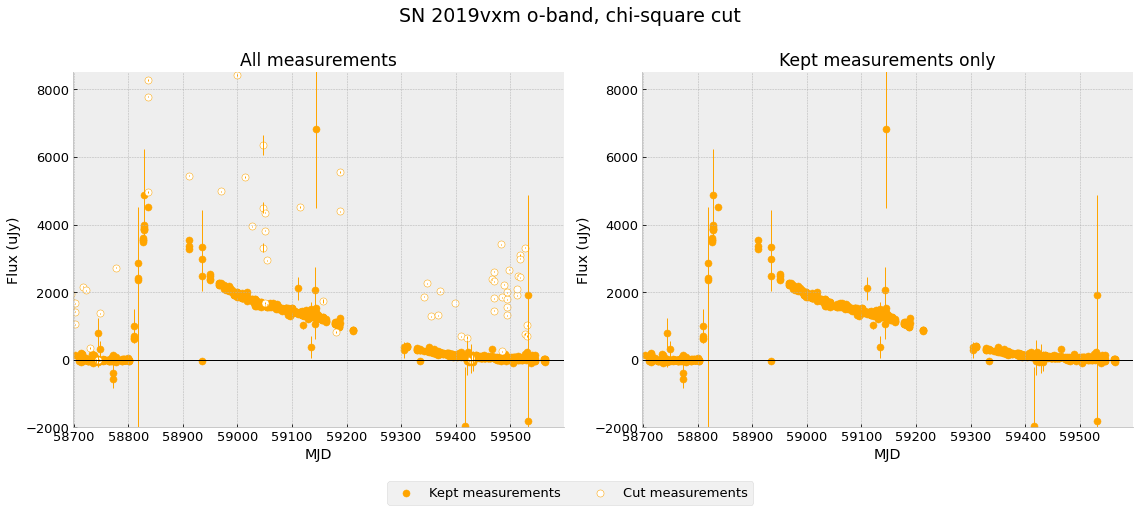

In [15]:
# plot the cut light curve

def plot_cut_lc(lc_type, mask, add2title=None, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    good_ix = lc_info[lc_type].ix_unmasked('Mask',maskval=mask)
    bad_ix = AnotB(lc_info[lc_type].getindices(),good_ix)

    fig, (cut, clean) = plt.subplots(1, 2, figsize=(16, 6.5), tight_layout=True)
    title = 'SN %s %s-band' % (lc_info['tnsname'], lc_info['filter'])
    if lc_type == 'avglc':
        title += ', averaged'
    if not(add2title is None):
        title += ', '+add2title
    plt.suptitle(title, fontsize=19, y=1)

    color = 'orange' if lc_info['filter'] == 'o' else 'cyan'
    
    if ylim_lower is None: ylim_lower = -2000
    if ylim_upper is None: 
        afterdiscdate_i = lc_info[lc_type].ix_inrange(colnames=['MJD'],lowlim=lc_info['discdate']) if lc_type == 'avglc' else lc_info['afterdiscdate_i']
        ylim_upper = scale*get_xth_percentile_flux(lc_type, 95, afterdiscdate_i)
    if xlim_lower is None: xlim_lower = lc_info['discdate'] - 200
    if xlim_upper is None: xlim_upper = lc_info['discdate'] + 800
    cut.set_ylim(ylim_lower, ylim_upper)
    cut.set_xlim(xlim_lower,xlim_upper)
    clean.set_ylim(ylim_lower, ylim_upper)
    clean.set_xlim(xlim_lower,xlim_upper)

    cut.spines.right.set_visible(False)
    cut.spines.top.set_visible(False)
    cut.errorbar(lc_info[lc_type].t.loc[good_ix,'MJD'], lc_info[lc_type].t.loc[good_ix,'uJy'], yerr=lc_info[lc_type].t.loc[good_ix,'duJy'], fmt='none',ecolor=color,elinewidth=1,c=color)
    cut.scatter(lc_info[lc_type].t.loc[good_ix,'MJD'], lc_info[lc_type].t.loc[good_ix,'uJy'], s=50,color=color,marker='o',label='Kept measurements')
    cut.errorbar(lc_info[lc_type].t.loc[bad_ix,'MJD'], lc_info[lc_type].t.loc[bad_ix,'uJy'], yerr=lc_info[lc_type].t.loc[bad_ix,'duJy'], fmt='none',mfc='white',ecolor=color,elinewidth=1,c=color)
    cut.scatter(lc_info[lc_type].t.loc[bad_ix,'MJD'], lc_info[lc_type].t.loc[bad_ix,'uJy'], s=50,facecolors='white',edgecolors=color,marker='o',label='Cut measurements')
    cut.set_title('All measurements')
    cut.axhline(linewidth=1,color='k')
    cut.set_xlabel('MJD')
    cut.set_ylabel('Flux (uJy)')

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),ncol=2)

    clean.spines.right.set_visible(False)
    clean.spines.top.set_visible(False)
    clean.errorbar(lc_info[lc_type].t.loc[good_ix,'MJD'], lc_info[lc_type].t.loc[good_ix,'uJy'], yerr=lc_info[lc_type].t.loc[good_ix,'duJy'], fmt='none',ecolor=color,elinewidth=1,c=color)
    clean.scatter(lc_info[lc_type].t.loc[good_ix,'MJD'], lc_info[lc_type].t.loc[good_ix,'uJy'], s=50,color=color,marker='o',label='Kept measurements')
    clean.set_title('Kept measurements only')
    clean.axhline(linewidth=1,color='k')
    clean.set_xlabel('MJD')
    clean.set_ylabel('Flux (uJy)')
    clean.set_ylim(ylim_lower, ylim_upper)

plot_cut_lc('lc', flag_chisquare, add2title='chi-square cut', xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

### Save the light curve with the new 'Mask' column

In [16]:
# Save the light curve with the new 'Mask' column?
save = False

# Overwrite the old light curve file?
overwrite_old_lc = False

# If not overriding old light curve file, enter new filename:
filename_new = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.lc.txt'

In [17]:
# save light curve
if save:
    print('Saving light curve with updated mask column...')
    if overwrite_old_lc:
        print('Overwriting old light curve file at %s... ' % filename)
        save_lc('lc',filename,overwrite=True) #lc_info['lc'].write(filename,overwrite=True)
    else:
        print('Writing new file at %s... ' % filename_new)
        save_lc('lc',filename_new,overwrite=True) #lc_info['lc'].write(filename_new,overwrite=True)

## Part 2: Static Uncertainty Cut

The following uncertainty cut implements a static cut that applies the same way to each light curve. The purpose of this cut is to identify and clean out the most egregious outliers with large uncertainties and small chi-square values not cut in the dynamic chi-square cut. The value of this cut was determined after calculating the typical uncertainty of bright stars just below the saturation limit. 

In [18]:
# You may change the following static uncertainty cut value to your liking;
# however, the default value is set to XXXX.
lc_info['uncertainty_cut'] = 160

In [19]:
# update 'Mask' column according to uncertainty cut

kept_i = lc_info['lc'].ix_inrange(colnames=['duJy'],uplim=lc_info['uncertainty_cut'])
cut_i = AnotB(lc_info['lc'].getindices(), kept_i)
update_mask_col(lc_info['lc'].t, flag_uncertainty, cut_i)

### Plot the ATLAS light curve with the chi-square and uncertainty cuts

In [20]:
# Optionally, manually enter the plot's x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

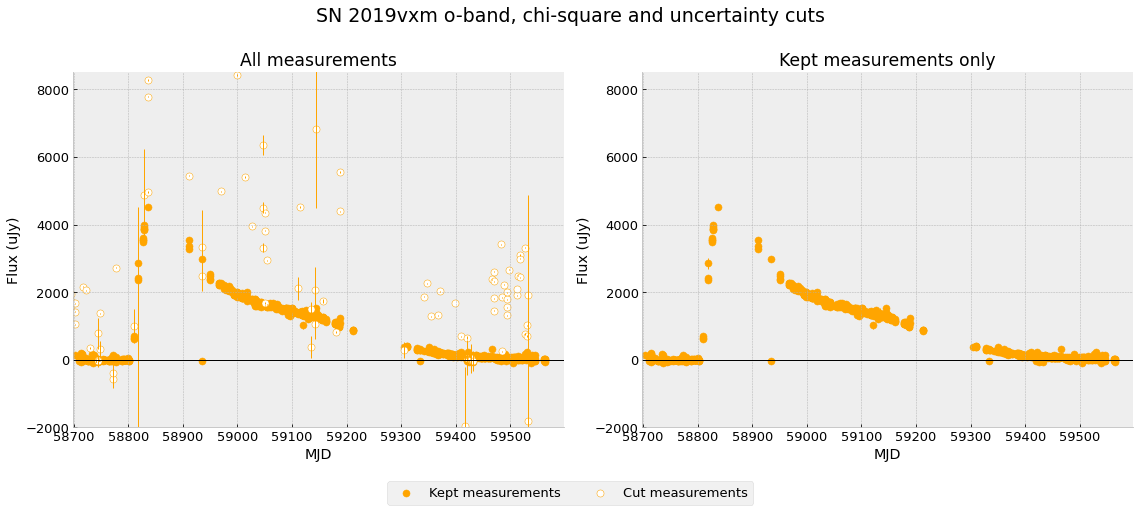

In [21]:
# plot the light curve

plot_cut_lc('lc', flag_uncertainty|flag_chisquare, add2title='chi-square and uncertainty cuts', xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

### Save the light curve with the new 'Mask' column

In [22]:
# Save the light curve with the new 'Mask' column?
save = False

# Overwrite the old light curve file?
overwrite_old_lc = False

# If not overwriting old light curve file, enter new filename:
filename_new = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.lc.txt'

In [23]:
# save light curve
if save:
    print('Saving light curve with updated mask column...')
    if overwrite_old_lc:
        print('Overwriting old light curve file at %s... ' % filename)
        save_lc('lc',filename,overwrite=True)
    else:
        print('Writing new file at %s... ' % filename_new)
        save_lc('lc',filename_new,overwrite=True)

## Part 3: Control Light Curves: 3σ-Clipped Average Cut [IN PROGRESS, DO NOT USE]

While the chi-square and uncertainty cuts are effective in cutting out a majority of the bad measurements, tricky cases may require a larger set of control light curves that can be used as a basis of comparison for inconsistent flux. In order to account for this inconsistent flux, we can obtain ~8 quality control forced photometry light curves in a 17" circle pattern around the SN location OR around a nearby bright object that may be poorly subtracting. Then, we use statistics from these control light curves to cut bad measurements from the SN light curve.

For a given epoch, we have 1 SN measurement for which we examine 8 control measurements within the same epoch. We know that if the control light curve measurements are NOT consistent with 0, this indicates something wrong with this epoch, so the SN measurement is unreliable. Therefore, we obtain statistics for the control light curves by calculating the 3σ-clipped average of the control flux. 

For the given epoch, we cut the SN measurement for which the returned control statistics fulfill any of the following criteria: 
- A returned chi-square > 2.5
- A returned abs(flux/dflux) > 3.0
- Number of clipped/"bad" measurements in the 3σ-clipped average > 2
- Number of used/"good" measurements in the 3σ-clipped average < 4

In [24]:
# Enter the bound for an epoch's maximum chi-square 
# (if x2 > x2_max, flag SN measurement):
x2_max = 3

# Enter the bound for an epoch's maximum abs(flux/dflux) ratio 
# (if abs(flux/dflux) > stn_max, flag SN measurement):
stn_max = 3.0

# Enter the bound for an epoch's maximum number of clipped control measurements
# (if Nclip > Nclip_max, flag SN measurement):
Nclip_max = 2

# Enter the bound for an epoch's minimum number of good control measurements
# (if Ngood < Ngood_min, flag SN measurement):
Ngood_min = 3


Calculating control light curve statistics...
Flagging SN light curve based on control light curve statistics...

Length of SN light curve: 1781
Percent of data above x2_max bound: 3.87%
Percent of data above stn_max bound: 1.12%
Percent of data above Nclip_max bound: 23.69%
Percent of data below Ngood_min bound: 0.62%
Total percent of data flagged as bad: 26.84%
Total percent of data flagged as questionable (not masked with control light curve flags but Nclip > 0): 67.32%


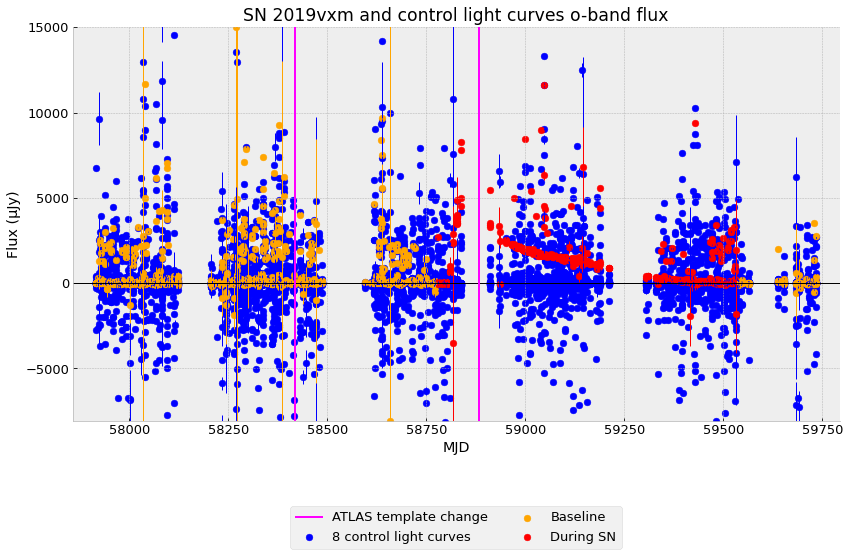

In [25]:
def get_control_stats(Ncontrols):
    print('\nCalculating control light curve statistics...')

    # construct arrays for control lc data
    uJy = np.full((Ncontrols, len(lc_info['lc'].t['MJD'])), np.nan)
    duJy = np.full((Ncontrols, len(lc_info['lc'].t['MJD'])), np.nan)
    Mask = np.full((Ncontrols, len(lc_info['lc'].t['MJD'])), 0, dtype=np.int32)
    
    for control_index in range(1,Ncontrols+1):
        if (len(controls[control_index].t) != len(lc_info['lc'].t['MJD'])) or (np.array_equal(lc_info['lc'].t['MJD'], controls[control_index].t['MJD']) is False):
            raise RuntimeError(f'ERROR: SN lc not equal to control lc for control_index {control_index}! Rerun or debug verify_mjds().')
        else:
            uJy[control_index-1,:] = controls[control_index].t['uJy']
            duJy[control_index-1,:] = controls[control_index].t['duJy']
            Mask[control_index-1,:] = controls[control_index].t['Mask']

    c2_param2columnmapping = lc_info['lc'].intializecols4statparams(prefix='c2_',format4outvals='{:.2f}',skipparams=['converged','i'])

    for index in range(uJy.shape[-1]):
        pda4MJD = pdastrostatsclass()
        pda4MJD.t['uJy'] = uJy[1:,index]
        pda4MJD.t['duJy'] = duJy[1:,index]
        pda4MJD.t['Mask'] = np.bitwise_and(Mask[1:,index], flag_chisquare|flag_uncertainty)
        
        pda4MJD.calcaverage_sigmacutloop('uJy',noisecol='duJy',maskcol='Mask',maskval=(flag_chisquare|flag_uncertainty),verbose=1,Nsigma=3.0,median_firstiteration=True)
        lc_info['lc'].statresults2table(pda4MJD.statparams, c2_param2columnmapping, destindex=index)

def controls_cut():
    print('Flagging SN light curve based on control light curve statistics...')

    lc_info['lc'].t['c2_abs_stn'] = lc_info['lc'].t['c2_mean']/lc_info['lc'].t['c2_mean_err']

    flag_x2_i = lc_info['lc'].ix_inrange(colnames=['c2_X2norm'], lowlim=x2_max, exclude_lowlim=True)
    flag_stn_i = lc_info['lc'].ix_inrange(colnames=['c2_abs_stn'], lowlim=stn_max, exclude_lowlim=True)
    flag_nclip_i = lc_info['lc'].ix_inrange(colnames=['c2_Nclip'], lowlim=Nclip_max, exclude_lowlim=True)
    flag_ngood_i = lc_info['lc'].ix_inrange(colnames=['c2_Ngood'], uplim=Ngood_min, exclude_uplim=True)

    lc_info['lc'].t.loc[flag_x2_i,'Mask'] |= flag_controls_x2
    lc_info['lc'].t.loc[flag_stn_i,'Mask'] |= flag_controls_stn
    lc_info['lc'].t.loc[flag_nclip_i,'Mask'] |= flag_controls_Nclip
    lc_info['lc'].t.loc[flag_ngood_i,'Mask'] |= flag_controls_Ngood

    zero_Nclip_i = lc_info['lc'].ix_equal('c2_Nclip', 0)
    unmasked_i = lc_info['lc'].ix_unmasked('Mask', maskval=flag_controls_x2|flag_controls_stn|flag_controls_Nclip|flag_controls_Ngood)
    lc_info['lc'].t.loc[AnotB(unmasked_i,zero_Nclip_i),'Mask'] |= flag_controls_questionable
    lc_info['lc'].t.loc[AnotB(lc_info['lc'].getindices(),unmasked_i),'Mask'] |= flag_controls_bad

def print_flag_stats():
    print('\nLength of SN light curve: %d' % len(lc_info['lc'].t))
    print('Percent of data above x2_max bound: %0.2f%%' % (100*len(lc_info['lc'].ix_masked('Mask',maskval=flag_controls_x2))/len(lc_info['lc'].t)))
    print('Percent of data above stn_max bound: %0.2f%%' % (100*len(lc_info['lc'].ix_masked('Mask',maskval=flag_controls_stn))/len(lc_info['lc'].t)))
    print('Percent of data above Nclip_max bound: %0.2f%%' % (100*len(lc_info['lc'].ix_masked('Mask',maskval=flag_controls_Nclip))/len(lc_info['lc'].t)))
    print('Percent of data below Ngood_min bound: %0.2f%%' % (100*len(lc_info['lc'].ix_masked('Mask',maskval=flag_controls_Ngood))/len(lc_info['lc'].t)))
    print('Total percent of data flagged as bad: %0.2f%%' % (100*len(lc_info['lc'].ix_masked('Mask',maskval=flag_controls_bad))/len(lc_info['lc'].t)))
    print('Total percent of data flagged as questionable (not masked with control light curve flags but Nclip > 0): %0.2f%%' % (100*len(lc_info['lc'].ix_masked('Mask',maskval=flag_controls_questionable))/len(lc_info['lc'].t)))
    
plot_control_lcs()
get_control_stats(Ncontrols)
controls_cut()
print_flag_stats()

### Plot the ATLAS light curve with the chi-square, uncertainty, and control light curve cuts

In [26]:
# Optionally, manually enter the plot's x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

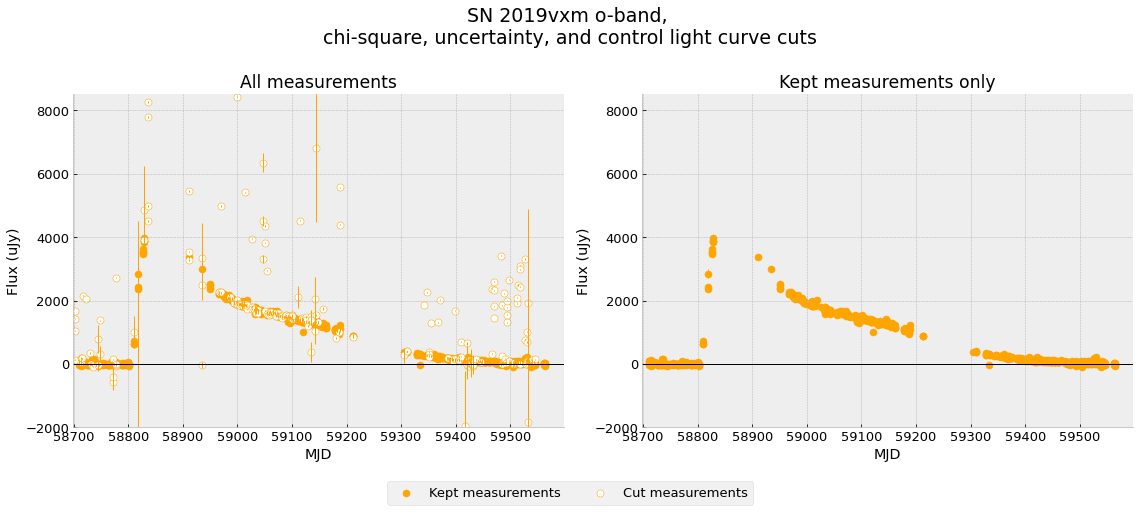

In [27]:
# plot the light curve

plot_cut_lc('lc', flag_controls_bad|flag_chisquare|flag_uncertainty, add2title='\nchi-square, uncertainty, and control light curve cuts', xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)#flag_uncertainty|flag_chisquare|flag_controls_bad, xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

### Save the light curve with the new 'Mask' column

In [28]:
# Save the light curve with the new 'Mask' column?
save = False

# Overwrite the old light curve file?
overwrite_old_lc = False

# If not overwriting old light curve file, enter new filename:
filename_new = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.lc.txt'

In [29]:
# save light curve
if save:
    print('Saving light curve with updated mask column...')
    if overwrite_old_lc:
        print('Overwriting old light curve file at %s... ' % filename)
        save_lc('lc',filename,overwrite=True)
    else:
        print('Writing new file at %s... ' % filename_new)
        save_lc('lc',filename_new,overwrite=True)

## Part 4: Averaging

Our goal is to identify and cut out bad days by taking a 3σ-clipped average of each day. For each day, we calculate the 3σ-clipped average of any SN measurements falling within that day and use that average as our flux for that day. Because the ATLAS survey takes about 4 exposures every 2 days, we usually average together approximately 4 measurements per epoch. However, out of these 4 exposures, only measurements not cut in the previous methods are averaged in the 3σ-clipped average cut. (The exception to this statement would be the case that all 4 measurements are cut in previous methods; in this case, they are averaged anyway and flagged as a bad day.)

Then we cut any measurements in the SN light curve for the given epoch for which statistics fulfill any of the following criteria: 
- A returned chi-square > 4.0
- Number of measurements averaged < 2
- Number of measurements clipped > 1

For this part of the cleaning, we still need to improve the cutting at the peak of the SN (important epochs are sometimes cut, maybe due to fast rise, etc.).

In [30]:
# Enter the MJD bin size in days:
mjdbinsize = 1

# Should MJD bins with no measurements be translated as NaN (True) 
# or removed from the averaged light curve (False)?
keep_empty_bins = False

# After flux is averaged, average magnitudes are calculated using a flux-to-magnitude conversion.
# Magnitudes are limits if the dmagnitude is NaN. Enter these magnitudes' sigma limit:
flux2mag_sigma_limit = 3

# Enter the bound for a bin's maximum number of clipped measurements
# (if Nclip > Nclip_max, flag day):
Nclip_max = 1

# Enter the bound for a bin's minimum number of good measurements
# (if Ngood < Ngood_min, flag day):
Ngood_min = 2

# Enter the bound for a bin's maximum chi-square (if x2 > x2_max, flag day):
x2_max = 4.0

In [31]:
# average the light curve

def average_lc(Nclip_max, Ngood_min, x2_max, flag_badday, flag_ixclip, flag_smallnum, mjdbinsize=1, flux2mag_sigma_limit=3.0, keep_empty_bins=True):
    mjd = int(np.amin(lc_info['lc'].t['MJD']))
    mjd_max = int(np.amax(lc_info['lc'].t['MJD']))+1

    good_i = lc_info['lc'].ix_unmasked('Mask', maskval=flag_chisquare|flag_uncertainty)

    while mjd <= mjd_max:
        range_i = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=mjd, uplim=mjd+mjdbinsize, exclude_uplim=True)
        range_good_i = AandB(range_i,good_i)

        # add new row to avglc if keep_empty_bins or any measurements present
        if keep_empty_bins or len(range_i) >= 1:
            new_row = {'MJDbin':mjd+0.5*mjdbinsize, 'Nclip':0, 'Ngood':0, 'Nexcluded':len(range_i)-len(range_good_i), 'Mask':0}
            avglc_index = lc_info['avglc'].newrow(new_row)
        
        # if no measurements present, flag or skip over day
        if len(range_i) < 1:
            if keep_empty_bins:
                update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])
            mjd += mjdbinsize
            continue
        
        # if no good measurements, average values anyway and flag
        if len(range_good_i) < 1:
            # average flux
            lc_info['lc'].calcaverage_sigmacutloop('uJy', noisecol='duJy', indices=range_i, Nsigma=3.0, median_firstiteration=True)
            fluxstatparams = deepcopy(lc_info['lc'].statparams)

            # average mjd
            # SHOULD NOISECOL HERE BE DUJY OR NONE??
            lc_info['lc'].calcaverage_sigmacutloop('MJD', noisecol='duJy', indices=fluxstatparams['ix_good'], Nsigma=0, median_firstiteration=False)
            avg_mjd = lc_info['lc'].statparams['mean']

            # add row and flag
            lc_info['avglc'].add2row(avglc_index, {'MJD':avg_mjd, 
                                                   'uJy':fluxstatparams['mean'], 
                                                   'duJy':fluxstatparams['mean_err'], 
                                                   'stdev':fluxstatparams['stdev'],
                                                   'x2':fluxstatparams['X2norm'],
                                                   'Nclip':fluxstatparams['Nclip'],
                                                   'Ngood':fluxstatparams['Ngood'],
                                                   'Mask':0})
            update_mask_col(lc_info['lc'].t, flag_badday, range_i)
            update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])

            mjd += mjdbinsize
            continue
        
        # average good measurements
        lc_info['lc'].calcaverage_sigmacutloop('uJy', noisecol='duJy', indices=range_good_i, Nsigma=3.0, median_firstiteration=True)
        fluxstatparams = deepcopy(lc_info['lc'].statparams)

        if fluxstatparams['mean'] is None or len(fluxstatparams['ix_good']) < 1:
            update_mask_col(lc_info['lc'].t, flag_badday, range_i)
            update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])
            mjd += mjdbinsize
            continue

        # average mjd
        # SHOULD NOISECOL HERE BE DUJY OR NONE??
        lc_info['lc'].calcaverage_sigmacutloop('MJD', noisecol='duJy', indices=fluxstatparams['ix_good'], Nsigma=0, median_firstiteration=False)
        avg_mjd = lc_info['lc'].statparams['mean']

        # add row
        lc_info['avglc'].add2row(avglc_index, {'MJD':avg_mjd, 
                                                   'uJy':fluxstatparams['mean'], 
                                                   'duJy':fluxstatparams['mean_err'], 
                                                   'stdev':fluxstatparams['stdev'],
                                                   'x2':fluxstatparams['X2norm'],
                                                   'Nclip':fluxstatparams['Nclip'],
                                                   'Ngood':fluxstatparams['Ngood'],
                                                   'Mask':0})
        
        # flag clipped measurements in lc
        if len(fluxstatparams['ix_clip']) > 0:
            update_mask_col(lc_info['lc'].t, flag_ixclip, fluxstatparams['ix_clip'])
        
        # if small number within this bin, flag measurements
        if len(range_good_i) < 3:
            update_mask_col(lc_info['lc'].t, flag_smallnum, range_good_i) # CHANGE TO RANGE_I??
            update_mask_col(lc_info['avglc'].t, flag_smallnum, [avglc_index])
        # else check sigmacut bounds and flag
        else:
            is_bad = False
            if fluxstatparams['Ngood'] < Ngood_min:
                is_bad = True
            if fluxstatparams['Nclip'] > Nclip_max:
                is_bad = True
            if not(fluxstatparams['X2norm'] is None) and fluxstatparams['X2norm'] > x2_max:
                is_bad = True
            if is_bad:
                update_mask_col(lc_info['lc'].t, flag_badday, range_i)
                update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])

        mjd += mjdbinsize
    
    # convert flux to magnitude and dflux to dmagnitude
    lc_info['avglc'].flux2mag('uJy','duJy','m','dm', zpt=23.9, upperlim_Nsigma=flux2mag_sigma_limit)

    print('Success')

    drop_extra_columns('avglc')

    for col in ['Nclip','Ngood','Nexcluded','Mask']: 
        lc_info['avglc'].t[col] = lc_info['avglc'].t[col].astype(np.int32)

if len(lc_info['lc'].t) < 1:
    print('ERROR: No data in lc so cannot average; exiting... ')
    sys.exit()

print('Averaging light curve with the following criteria: Nclip_max = %d, Ngood_min = %d, x2_max = %0.2f... ' % (Nclip_max, Ngood_min, x2_max))
lc_info['avglc'] = pdastrostatsclass(columns=['MJD','MJDbin','uJy','duJy','stdev','x2','Nclip','Ngood','Nexcluded','Mask'],hexcols=['Mask'])
average_lc(Nclip_max, Ngood_min, x2_max, flag_badday, flag_ixclip, flag_smallnum, keep_empty_bins=keep_empty_bins)

Averaging light curve with the following criteria: Nclip_max = 1, Ngood_min = 2, x2_max = 4.00... 
Success
Dropping extra columns:  ['__tmp_SN']


### Plot the averaged light curve

In [32]:
# Optionally, manually enter the plot's x and y limits:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

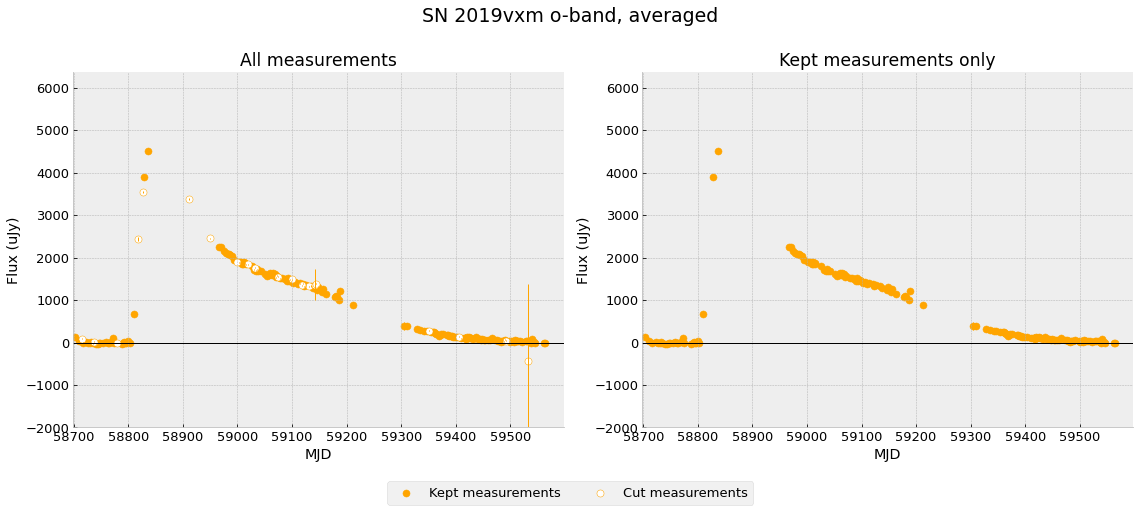

In [33]:
# plot averaged light curve

plot_cut_lc('avglc', flag_chisquare|flag_uncertainty|flag_badday, xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

### Save the averaged light curve with the new 'Mask' column

In [34]:
# Save the light curve with the new 'Mask' column?
save = True

# Overwrite the old light curve file?
overwrite_old_lc = False

# If not overwriting old light curve file, enter new filename:
filename_new = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.1.00days.lc.txt'

In [35]:
# save light curve
if save:
    print('Saving light curve with updated mask column...')
    if overwrite_old_lc:
        print('Overwriting old light curve file at %s... ' % filename)
        save_lc('avglc',filename,overwrite=True) #lc_info['lc'].write(filename,overwrite=True)
    else:
        print('Writing new file at %s... ' % filename_new)
        save_lc('avglc',filename_new,overwrite=True) #lc_info['lc'].write(filename_new,overwrite=True)

Saving light curve with updated mask column...
Writing new file at /Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.1.00days.lc.txt... 
Saving light curve at /Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.1.00days.lc.txt
